In [ ]:
#Importing libraries  
from keras.layers import *
from keras.models import Model, load_model
from keras.datasets import mnist, fashion_mnist
from keras.callbacks import ReduceLROnPlateau
from keras import regularizers
from keras import optimizers
from keras import backend as K
import scipy
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea
import pandas as pd
import numpy as np

Using TensorFlow backend.


In [ ]:
#load data into variables
(x_train,_), (x_test,_) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 2s 0us/step


In [ ]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [ ]:
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

In [ ]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

- Let's Implement convolutional Autoencoders.

In [ ]:
def conv_autoEncoder():
  inp = Input(shape=(28,28,1))
  x = Conv2D(64, (3, 3), activation='relu', padding='same')(inp)
  x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2))(x)
  x = BatchNormalization()(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2))(x)
  x = BatchNormalization()(x)
  x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
  x = Conv2D(4, (2, 2), activation='relu', padding='same')(x)
  x = Conv2D(1, (2, 2), activation='relu', padding='same')(x)
  x = Flatten()(x)
  encoded = Dense(2, activation='relu')(x)
  encoder = Model(inputs=inp, outputs=encoded)
  encoded_inputs = Input(shape=(2,))
  x = Dense(4, activation='relu')(encoded_inputs)
  x = Reshape((2, 2, 1))(x)
  x = Conv2D(4, (2, 2), activation='relu', padding='same')(x)
  x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  x = UpSampling2D((7, 7))(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

  decoder = Model(inputs=encoded_inputs, outputs=decoded)
    
  x = encoder(inp)
  x = decoder(x)
  model = Model(inputs=inp, outputs=x)
  model.compile(optimizer=optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy', 'mse'])
  print(model.summary())
    
  clr = ReduceLROnPlateau(
      monitor='loss',
      factor=0.5,
      patience=3,
      min_delta=0.01,
      cooldown=0,
      min_lr=1e-7,
      verbose=1)

  model.fit(
      x_train,
      x_train,
      batch_size=256,
      epochs=50,
      shuffle=True,
      validation_data=(x_test, x_test),
      callbacks=[clr])

  return model, encoder, decoder

model, encoder, decoder = conv_autoEncoder()  

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
model_1 (Model)              (None, 2)                 72233     
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 1)         42417     
Total params: 114,650
Trainable params: 114,362
Non-trainable params: 288
_________________________________________________________________
None
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 35s 575us/step - loss: 0.4269 - accuracy: 0.4884 - mse: 0.0634 - val_loss: 0.6163 - val_accuracy: 0.4999 - val_mse: 0.1310
Epoch 2/50
60000/60000 [==============================] - 26s 440us/step - loss: 0.3784 - accuracy: 0.4958 - mse: 0.0457 - val_loss: 0.5746 - val

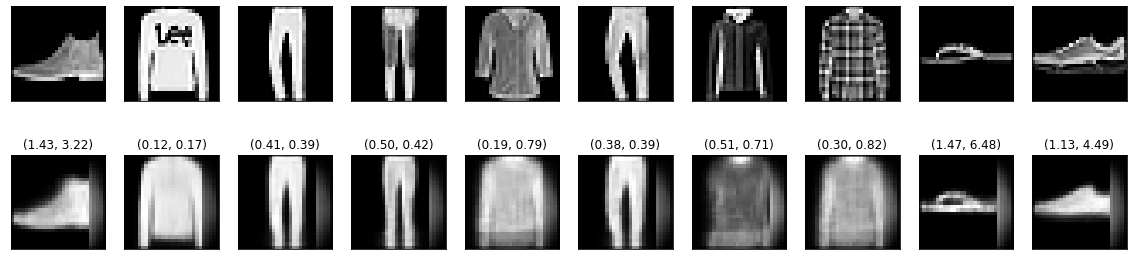

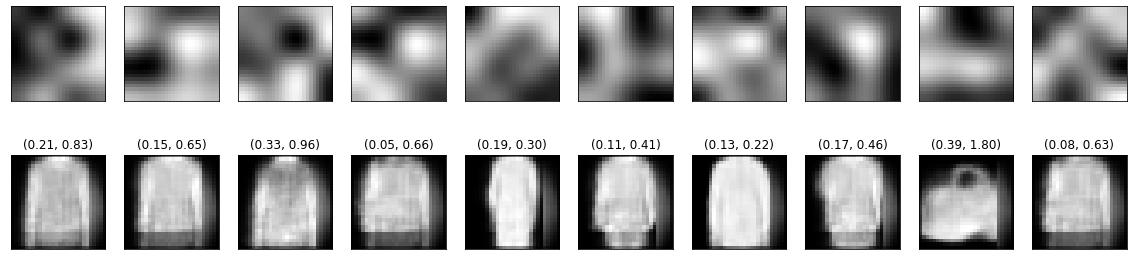

In [ ]:
def get_triple(inputs):
    latent_repr = encoder.predict(inputs)
    outputs = decoder.predict(latent_repr)
    latent_repr = latent_repr.reshape((latent_repr.shape[0], latent_repr.shape[1], 1))

    return inputs, latent_repr, outputs

def show_encodings(inputs, latent_repr, outputs):
    n = len(inputs)
    fig, axes = plt.subplots(2, n, figsize=(2*n, 5))
    for i in range(n):
        axes[1, i].set_title('({0:.2f}, {1:.2f})'.format(float(latent_repr[i, 0]), float(latent_repr[i, 1])))
        axes[0, i].imshow(inputs[i].reshape(28, 28), cmap='gray')
        axes[1, i].imshow(outputs[i].reshape(28, 28), cmap='gray')
    for ax in axes.flatten():
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
show_encodings(*get_triple(x_test[:10]))
inputs = np.random.random(size=(10, 4, 4, 1))
inputs = scipy.ndimage.zoom(inputs, (1, 7, 7, 1))
show_encodings(*get_triple(inputs))

- play around

In [ ]:
def conv_autoEncoder_2():
  inp = Input(shape=(28,28,1))
  x = Conv2D(64, (3, 3), activation='relu', padding='same')(inp)
  #x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2))(x)
  x = BatchNormalization()(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  #x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2))(x)
  x = BatchNormalization()(x)
  x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
  x = Conv2D(4, (2, 2), activation='relu', padding='same')(x)
  x = Conv2D(1, (2, 2), activation='relu', padding='same')(x)
  x = Flatten()(x)
  encoded = Dense(2, activation='relu')(x)
  encoder_2 = Model(inputs=inp, outputs=encoded)
  encoded_inputs = Input(shape=(2,))
  x = Dense(4, activation='relu')(encoded_inputs)
  x = Reshape((2, 2, 1))(x)
  x = Conv2D(4, (2, 2), activation='relu', padding='same')(x)
  x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  x = UpSampling2D((7, 7))(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  #x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  #x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

  decoder_2 = Model(inputs=encoded_inputs, outputs=decoded)
    
  x = encoder_2(inp)
  x = decoder_2(x)
  model_2 = Model(inputs=inp, outputs=x)
  model_2.compile(optimizer=optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy', 'mse'])
  print(model_2.summary())
    
  clr = ReduceLROnPlateau(
      monitor='loss',
      factor=0.5,
      patience=3,
      min_delta=0.01,
      cooldown=0,
      min_lr=1e-7,
      verbose=1)

  model_2.fit(
      x_train,
      x_train,
      batch_size=256,
      epochs=30,
      shuffle=True,
      validation_data=(x_test, x_test),
      callbacks=[clr])

  return model_2, encoder_2, decoder_2

model_2, encoder_2, decoder_2 = conv_autoEncoder_2() 

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
model_4 (Model)              (None, 2)                 31177     
_________________________________________________________________
model_5 (Model)              (None, 28, 28, 1)         23921     
Total params: 55,098
Trainable params: 54,810
Non-trainable params: 288
_________________________________________________________________
None
Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 16s 261us/step - loss: 0.4655 - accuracy: 0.4877 - mse: 0.0762 - val_loss: 1.0789 - val_accuracy: 0.4999 - val_mse: 0.1922
Epoch 2/30
60000/60000 [==============================] - 14s 241us/step - loss: 0.4432 - accuracy: 0.4930 - mse: 0.0684 - val_loss: 0.6677 - val_a

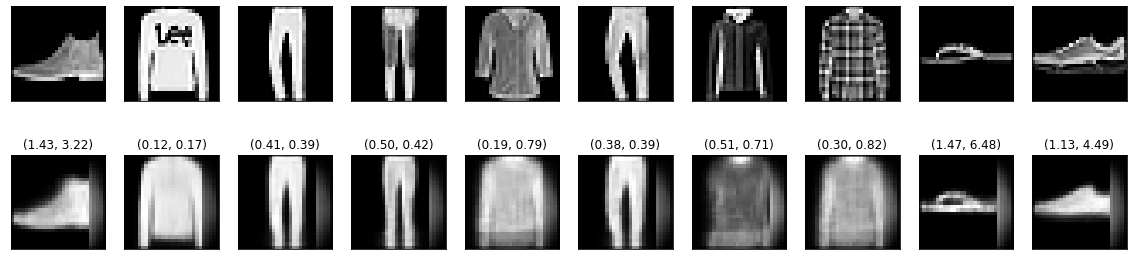

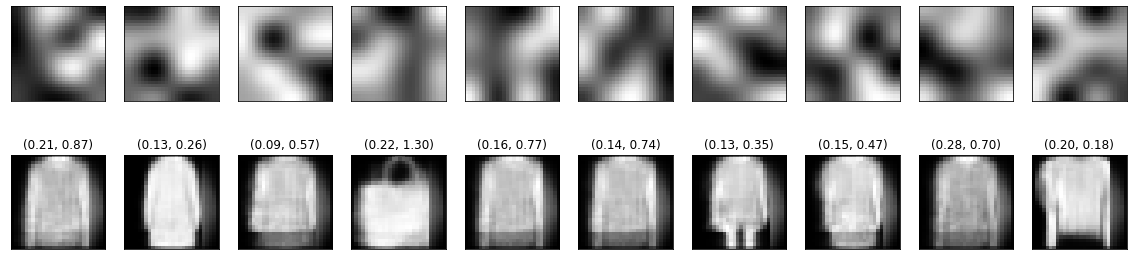

In [ ]:
def get_triple(inputs):
    latent_repr = encoder.predict(inputs)
    outputs = decoder.predict(latent_repr)
    latent_repr = latent_repr.reshape((latent_repr.shape[0], latent_repr.shape[1], 1))

    return inputs, latent_repr, outputs

def show_encodings(inputs, latent_repr, outputs):
    n = len(inputs)
    fig, axes = plt.subplots(2, n, figsize=(2*n, 5))
    for i in range(n):
        axes[1, i].set_title('({0:.2f}, {1:.2f})'.format(float(latent_repr[i, 0]), float(latent_repr[i, 1])))
        axes[0, i].imshow(inputs[i].reshape(28, 28), cmap='gray')
        axes[1, i].imshow(outputs[i].reshape(28, 28), cmap='gray')
    for ax in axes.flatten():
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
show_encodings(*get_triple(x_test[:10]))
inputs = np.random.random(size=(10, 4, 4, 1))
inputs = scipy.ndimage.zoom(inputs, (1, 7, 7, 1))
show_encodings(*get_triple(inputs))